In [21]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Flatten, Concatenate, TimeDistributed, Conv2D, MaxPooling2D
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import os
import matplotlib.pyplot as plt



# Función para convertir el formato de timestamp del DataFrame al formato de los nombres de las imágenes
def get_closest_image_path(timestamp, image_folder):
    base_image_name = f'OR_ABI-L2-ACMF-M6_G16_s{timestamp.strftime("%Y%m%d%H%M")}'
    for second in range(60):
        image_name = f"{base_image_name}{second:02d}.png"
        image_path = os.path.join(image_folder, image_name)
        if os.path.exists(image_path):
            return image_path
    return None

# Cargar imágenes y valores GHI normalizados, con imágenes redimensionadas
def load_images_and_ghi(df_filtrado, image_folder):
    images = []
    ghi_values = []
    doy_sin = []
    doy_cos = []

    # Inicializar la última imagen válida con una imagen de ceros por si es la primera vez
    last_valid_image = np.zeros((64, 64, 3), dtype=np.float32)
    
    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        doy_sin_value = row['DoY Sin']
        doy_cos_value = row['DoY Cos']
        image_path = get_closest_image_path(timestamp, image_folder)
         
        img = cv2.imread(image_path)
        
        if img is not None:
            # Redimensionar la imagen a 64x64 píxeles y normalizar dividiendo por 255
            img_resized = cv2.resize(img, (64, 64)) / 255.0
            last_valid_image = img_resized  # Actualizar la última imagen válida
        else:
            # Usar la última imagen válida (Forward Fill)
            img_resized = last_valid_image
            print(f"Imagen no encontrada: {image_path}, usando la última imagen válida.")
        
        # Agregar los valores a las listas correspondientes
        images.append(img_resized)
        ghi_values.append(ghi_value)
        doy_sin.append(doy_sin_value)
        doy_cos.append(doy_cos_value)
    
    # Normalizar los valores GHI
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)
    
    # Convertir doy_sin y doy_cos a numpy arrays
    doy_sin = np.array(doy_sin).reshape(-1, 1)
    doy_cos = np.array(doy_cos).reshape(-1, 1)
    
    return np.array(images), ghi_values_scaled, scaler, doy_sin, doy_cos

# Preparar secuencias para la LSTM (ahora prediciendo 12 pasos en el futuro)
def create_sequences(images, aux_features, ghi_values, time_steps, n_steps=12):
    X_images_seq = []
    X_aux_seq = []
    y_seq = []

    for i in range(len(images) - time_steps - n_steps + 1):
        # Crear secuencia de imágenes de longitud `time_steps`
        X_images_seq.append(images[i:i + time_steps])
        
        # Crear secuencia de características auxiliares de longitud `time_steps`
        X_aux_seq.append(aux_features[i:i + time_steps])
        
        # La variable objetivo es una secuencia de `n_steps` valores GHI después del último paso de la secuencia
        y_seq.append(ghi_values[i + time_steps:i + time_steps + n_steps].flatten())

    return np.array(X_images_seq), np.array(X_aux_seq), np.array(y_seq)

# Cargar datos y preparar el conjunto de entrenamiento
df = pd.read_pickle('/home/aia-workstation/Documents/Santiago/Modelo/Cloud_Forecasting_CNN_LSTM/df_GHI.plk')

# 1. Definir el rango de fechas para el entrenamiento
fecha_inicio_entrenamiento = '2023-01-01 05:00:00'  # Fecha de inicio de entrenamiento
fecha_fin_entrenamiento = '2023-02-28 18:30:00'  # Fecha de fin de entrenamiento

# Filtrar el DataFrame por el rango de entrenamiento
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # Asegurar que la columna Timestamp sea de tipo datetime
df_entrenamiento = df[(df['Timestamp'] >= fecha_inicio_entrenamiento) & (df['Timestamp'] <= fecha_fin_entrenamiento)]

# Cargar imágenes y valores GHI para el entrenamiento
image_folder = '/home/aia-workstation/Documents/Santiago/Modelo/Cloud_Forecasting_CNN_LSTM/Images/ACMF'
X_images_train, y_ghi_train, scaler_train, doy_sin_train, doy_cos_train = load_images_and_ghi(df_entrenamiento, image_folder)

# Concatenar DOY sin y cos con las imágenes
X_aux_features_train = np.concatenate([doy_sin_train, doy_cos_train], axis=1)

# Crear las secuencias con time_steps = 12 y n_steps = 12 (para predecir los próximos 12 pasos)
time_steps = 12
n_steps = 12
X_images_train_seq, X_aux_train_seq, y_train_seq = create_sequences(X_images_train, X_aux_features_train, y_ghi_train, time_steps, n_steps)

# Crear el modelo CNN + LSTM para predecir múltiples pasos hacia adelante
def create_cnn(f1, f2, f3, k1, k2, a1, a2, a3):
    model = Sequential()
    model.add(Conv2D(f1, (k1, k2), activation=a1, input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(f2, (k1, k2), activation=a2))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(f3, (3, 3), activation=a3))  # Reducir tamaño del kernel para evitar salida negativa
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    return model



Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@2802.216] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@2804.835] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@2807.446] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@2807.508] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@2808.398] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@2810.064] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@2810.126] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


In [ ]:

# Definir el modelo final con los mejores hiperparámetros encontrados
image_input = Input(shape=(time_steps, 64, 64, 3))
cnn = create_cnn(41, 25, 67, 7, 3, 'relu', 'relu', 'relu')
time_distributed_cnn = TimeDistributed(cnn)(image_input)

lstm = LSTM(127, return_sequences=False)(time_distributed_cnn)

aux_input = Input(shape=(time_steps, 2))
aux_lstm = LSTM(32, return_sequences=False)(aux_input)

concatenated = Concatenate()([lstm, aux_lstm])
concatenated = Dense(98, activation='relu')(concatenated)
concatenated = Dense(45, activation='relu')(concatenated)
concatenated = Dropout(0.2527314214599514)(concatenated)

# Cambiar la salida para predecir 12 pasos en el futuro
dense_output = Dense(n_steps, activation='linear')(concatenated)

# Definir el modelo completo
model = Model(inputs=[image_input, aux_input], outputs=dense_output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo final
model.fit([X_images_train_seq, X_aux_train_seq], y_train_seq, epochs=50, batch_size=32, validation_split=0.2)



Imagen no encontrada: None
Imagen no encontrada: None
Imagen no encontrada: None
Imagen no encontrada: None


[ WARN:0@1327.182] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@1327.283] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@1327.343] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@1327.355] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None
Imagen no encontrada: None


[ WARN:0@1327.534] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@1327.716] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None
Imagen no encontrada: None
Imagen no encontrada: None
Imagen no encontrada: None
Imagen no encontrada: None


[ WARN:0@1328.065] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@1328.065] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@1328.065] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@1328.066] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@1328.066] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
MAE en el conjunto de prueba: 0.18565321774378798
RMSE en el conjunto de prueba: 0.2369401004822477


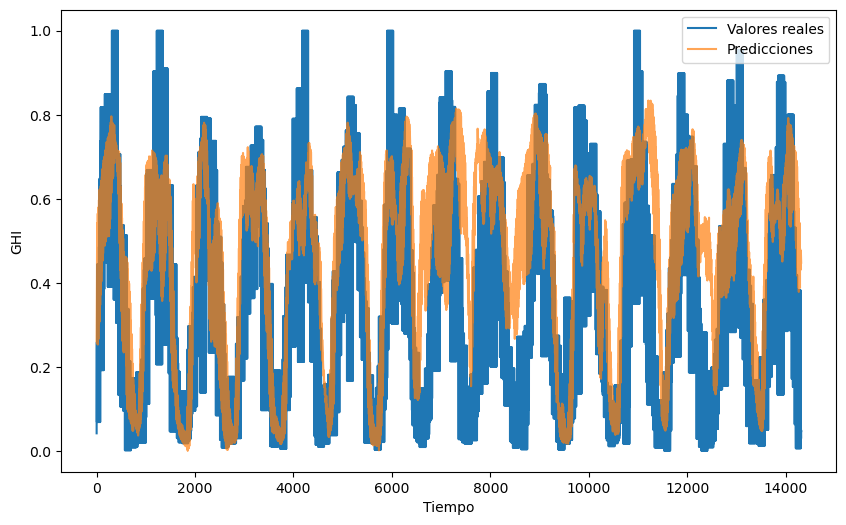

In [9]:



# Probar el modelo
# Preparar el conjunto de prueba (días nubosos)
fecha_inicio_prueba = '2023-03-1 05:00:00'  # Fecha de inicio de prueba
fecha_fin_prueba = '2023-03-15 18:00:00'  # Fecha de fin de prueba

# Filtrar el DataFrame por el rango de prueba
df_prueba = df[(df['Timestamp'] >= fecha_inicio_prueba) & (df['Timestamp'] <= fecha_fin_prueba)]

# Cargar imágenes y valores GHI para el conjunto de prueba
X_images_test, y_ghi_test, scaler_test, doy_sin_test, doy_cos_test = load_images_and_ghi(df_prueba, image_folder)

# Concatenar DOY sin y cos con las imágenes de prueba
X_aux_features_test = np.concatenate([doy_sin_test, doy_cos_test], axis=1)

# Crear las secuencias de prueba con time_steps 
X_images_test_seq, X_aux_test_seq, y_test_seq = create_sequences(X_images_test, X_aux_features_test, y_ghi_test, time_steps,n_steps)

# Hacer predicciones
y_pred = model.predict([X_images_test_seq, X_aux_test_seq])

# Invertir la normalización para GHI
y_test_seq_inversed = scaler_test.inverse_transform(y_test_seq)
y_pred_inversed = scaler_test.inverse_transform(y_pred)

# Evaluar el modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_seq_inversed, y_pred_inversed)
rmse = np.sqrt(mean_squared_error(y_test_seq_inversed, y_pred_inversed))

print(f'MAE en el conjunto de prueba: {mae}')
print(f'RMSE en el conjunto de prueba: {rmse}')

# Visualizar algunas predicciones
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq_inversed.flatten(), label='Valores reales')
plt.plot(y_pred_inversed.flatten(), label='Predicciones', alpha=0.7)
plt.xlabel('Tiempo')
plt.ylabel('GHI')
plt.legend()
plt.show()


plt.show()

R² del modelo en el conjunto de prueba: 0.027


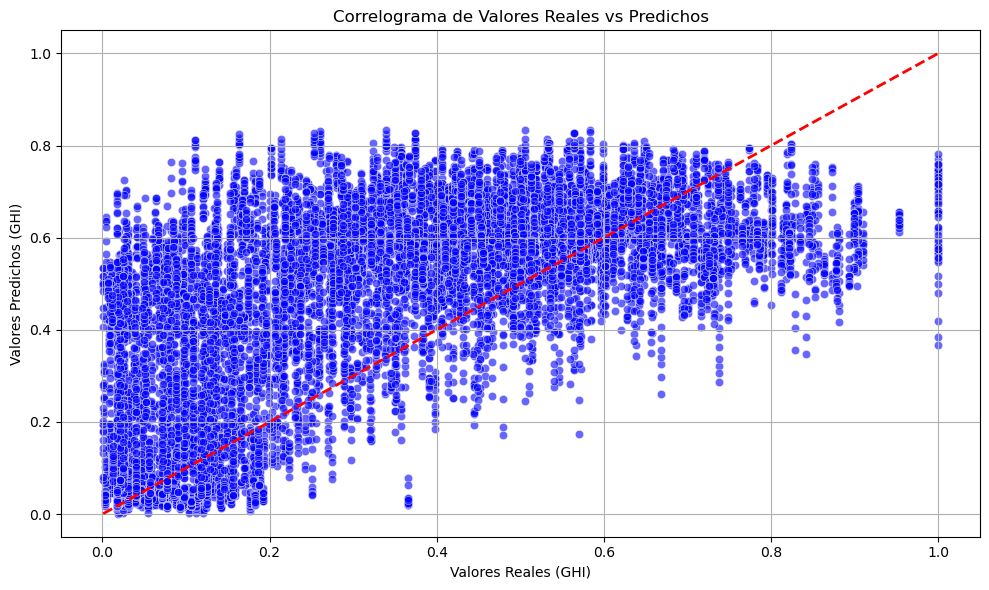

Step 1: MAE = 0.179, RMSE = 0.230
Step 2: MAE = 0.179, RMSE = 0.230
Step 3: MAE = 0.179, RMSE = 0.229
Step 4: MAE = 0.177, RMSE = 0.227
Step 5: MAE = 0.180, RMSE = 0.231
Step 6: MAE = 0.182, RMSE = 0.233
Step 7: MAE = 0.183, RMSE = 0.233
Step 8: MAE = 0.185, RMSE = 0.236
Step 9: MAE = 0.190, RMSE = 0.241
Step 10: MAE = 0.195, RMSE = 0.247
Step 11: MAE = 0.199, RMSE = 0.252
Step 12: MAE = 0.200, RMSE = 0.252


In [10]:
import seaborn as sns
from sklearn.metrics import r2_score

# Calcular el coeficiente de determinación R^2 para evaluar el ajuste de las predicciones
r2 = r2_score(y_test_seq_inversed.flatten(), y_pred_inversed.flatten())
print(f'R² del modelo en el conjunto de prueba: {r2:.3f}')

# Crear un correlograma (scatter plot) de los valores predichos vs los valores reales
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_seq_inversed.flatten(), y=y_pred_inversed.flatten(), alpha=0.6, color='b')
plt.xlabel('Valores Reales (GHI)')
plt.ylabel('Valores Predichos (GHI)')
plt.title('Correlograma de Valores Reales vs Predichos')
plt.plot([y_test_seq_inversed.min(), y_test_seq_inversed.max()],
         [y_test_seq_inversed.min(), y_test_seq_inversed.max()],
         color='red', linestyle='--', linewidth=2)  # Línea de referencia y=x
plt.grid(True)
plt.tight_layout()
plt.show()

for step in range(12):
    mae = mean_absolute_error(y_test_seq_inversed[:, step], y_pred_inversed[:, step])
    rmse = np.sqrt(mean_squared_error(y_test_seq_inversed[:, step], y_pred_inversed[:, step]))
    print(f'Step {step + 1}: MAE = {mae:.3f}, RMSE = {rmse:.3f}')


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_29', 'keras_tensor_63']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


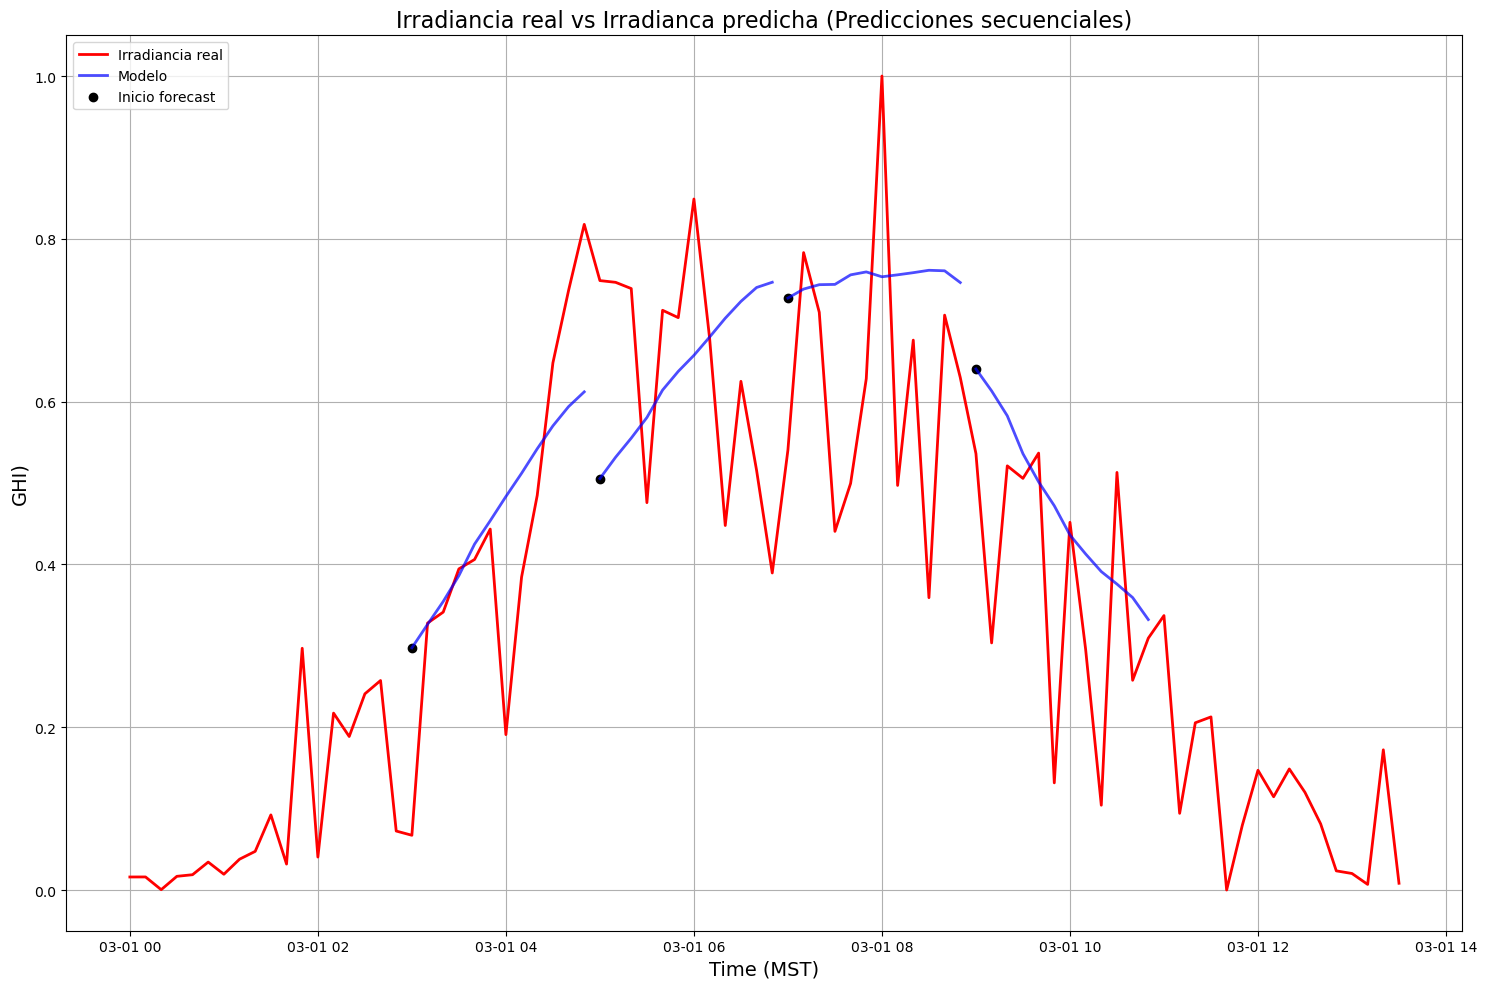

In [12]:
# Probar el modelo - Predicciones a lo largo de un día completo
fecha_inicio_prueba = '2023-03-01 00:00:00'  # Fecha de inicio de prueba
fecha_fin_prueba = '2023-03-01 23:00:00'  # Fecha de fin de prueba

# Filtrar el DataFrame por el rango de prueba
df_prueba = df[(df['Timestamp'] >= fecha_inicio_prueba) & (df['Timestamp'] <= fecha_fin_prueba)]

# Cargar imágenes y valores GHI para el conjunto de prueba
X_images_test, y_ghi_test, scaler_test, doy_sin_test, doy_cos_test= load_images_and_ghi(df_prueba, image_folder)

# Concatenar DOY sin y cos con las imágenes de prueba
X_aux_features_test = np.concatenate([doy_sin_test, doy_cos_test], axis=1)

# Crear las secuencias de prueba con time_steps (para tener predicciones a lo largo de todo el día)
time_steps = 18
n_steps = 12
X_images_test_seq, X_aux_test_seq, y_test_seq = create_sequences(X_images_test, X_aux_features_test, y_ghi_test, time_steps, n_steps)

# Hacer predicciones para todas las secuencias del día
y_pred = model.predict([X_images_test_seq, X_aux_test_seq])

# Invertir la normalización para GHI
y_test_seq_inversed = scaler_test.inverse_transform(y_test_seq.reshape(-1, 1)).reshape(y_test_seq.shape)
y_pred_inversed = scaler_test.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)



import matplotlib.dates as mdates

# Graficar el comportamiento diario - Real versus Predicción con intervalos secuenciales
plt.figure(figsize=(15, 10))

# Definir etiquetas de tiempo para el eje X
horas = pd.date_range(start=fecha_inicio_prueba, periods=len(y_ghi_test), freq='10min')

# Graficar valores reales de irradiancia
plt.plot(horas, y_ghi_test, color='red', label='Irradiancia real', linewidth=2)

# Graficar predicciones a lo largo del día, donde cada nueva predicción empieza después de la anterior
for i in range(0, len(y_pred_inversed), n_steps):
    if i + n_steps > len(y_pred_inversed):
        break

    # Extraer la secuencia de horas para la predicción actual
    pred_horas = horas[i + time_steps: i + time_steps + n_steps]

    # Graficar la predicción actual
    plt.plot(pred_horas, y_pred_inversed[i], color='blue', alpha=0.7, label='Modelo' if i == 0 else "", linewidth=2)

    # Marcar solo el primer punto de la predicción con un punto negro (inicio de la predicción)
    plt.scatter(pred_horas[0], y_pred_inversed[i][0], color='black', marker='o', label='Inicio forecast' if i == 0 else "")


# Añadir leyenda y títulos para mayor claridad
plt.xlabel('Time (MST)', fontsize=14)
plt.ylabel('GHI)', fontsize=14)
plt.title('Irradiancia real vs Irradianca predicha (Predicciones secuenciales)', fontsize=16)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()



Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la úl

[ WARN:0@2947.764] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@2947.765] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@2947.766] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@2947.767] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@2947.767] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@2947.768] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@2947.768] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@2947.769] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@2947.770] global loadsave.cpp:241 findDecoder imread_(''): can'

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


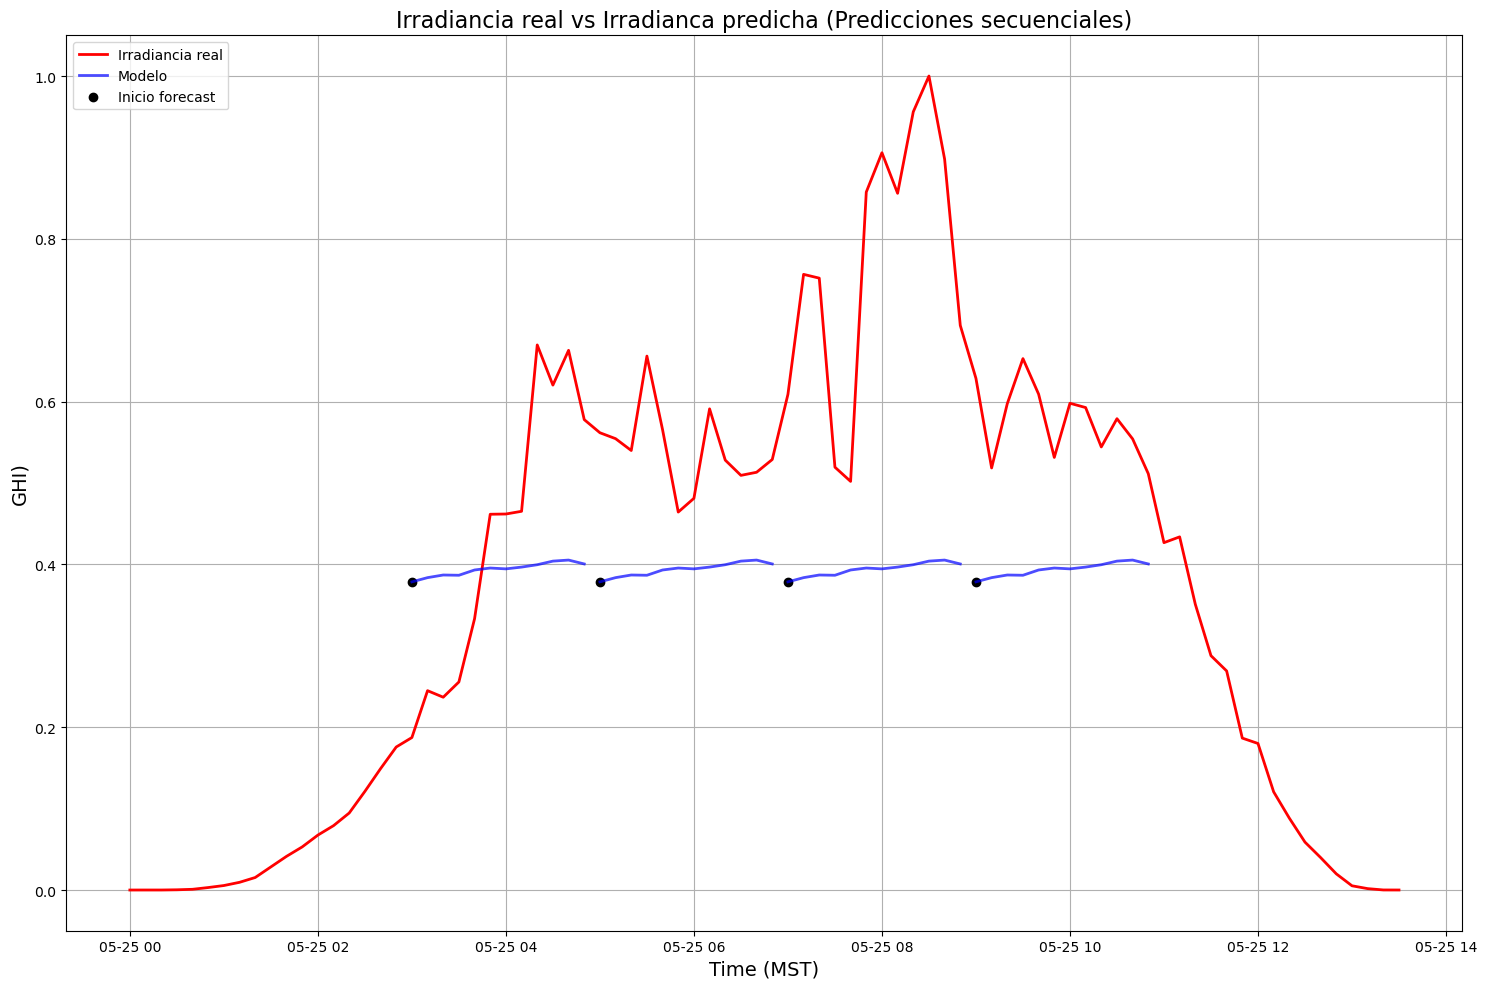

In [24]:

# Probar el modelo - Predicciones a lo largo de un día completo
fecha_inicio_prueba = '2023-05-25 00:00:00'  # Fecha de inicio de prueba
fecha_fin_prueba = '2023-05-25 23:00:00'  # Fecha de fin de prueba

# Filtrar el DataFrame por el rango de prueba
df_prueba = df[(df['Timestamp'] >= fecha_inicio_prueba) & (df['Timestamp'] <= fecha_fin_prueba)]

# Cargar imágenes y valores GHI para el conjunto de prueba
X_images_test, y_ghi_test, scaler_test, doy_sin_test, doy_cos_test= load_images_and_ghi(df_prueba, image_folder)

# Concatenar DOY sin y cos con las imágenes de prueba
X_aux_features_test = np.concatenate([doy_sin_test, doy_cos_test], axis=1)

# Crear las secuencias de prueba con time_steps (para tener predicciones a lo largo de todo el día)
time_steps = 18
n_steps = 12
X_images_test_seq, X_aux_test_seq, y_test_seq = create_sequences(X_images_test, X_aux_features_test, y_ghi_test, time_steps, n_steps)

# Hacer predicciones para todas las secuencias del día
y_pred = model.predict([X_images_test_seq, X_aux_test_seq])

# Invertir la normalización para GHI
y_test_seq_inversed = scaler_test.inverse_transform(y_test_seq.reshape(-1, 1)).reshape(y_test_seq.shape)
y_pred_inversed = scaler_test.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)



import matplotlib.dates as mdates

# Graficar el comportamiento diario - Real versus Predicción con intervalos secuenciales
plt.figure(figsize=(15, 10))

# Definir etiquetas de tiempo para el eje X
horas = pd.date_range(start=fecha_inicio_prueba, periods=len(y_ghi_test), freq='10min')

# Graficar valores reales de irradiancia
plt.plot(horas, y_ghi_test, color='red', label='Irradiancia real', linewidth=2)

# Graficar predicciones a lo largo del día, donde cada nueva predicción empieza después de la anterior
for i in range(0, len(y_pred_inversed), n_steps):
    if i + n_steps > len(y_pred_inversed):
        break

    # Extraer la secuencia de horas para la predicción actual
    pred_horas = horas[i + time_steps: i + time_steps + n_steps]

    # Graficar la predicción actual
    plt.plot(pred_horas, y_pred_inversed[i], color='blue', alpha=0.7, label='Modelo' if i == 0 else "", linewidth=2)

    # Marcar solo el primer punto de la predicción con un punto negro (inicio de la predicción)
    plt.scatter(pred_horas[0], y_pred_inversed[i][0], color='black', marker='o', label='Inicio forecast' if i == 0 else "")


# Añadir leyenda y títulos para mayor claridad
plt.xlabel('Time (MST)', fontsize=14)
plt.ylabel('GHI)', fontsize=14)
plt.title('Irradiancia real vs Irradianca predicha (Predicciones secuenciales)', fontsize=16)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

